## Librerías

In [1]:
# Libraries which will help us to manipulate a lil bit more our data
import numpy as np
import pandas as pd

# pandas: display all columns
pd.set_option('display.max_columns', None)

# Sklearn: Library for Train/Test Split // confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# TensorFlow: Library for model training
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Matplotlib: Library for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Functions: Library which contains all the functions that we'll use
import functions as fn

# Functions: Library which contains all the visualizations that we'll plot
import visualizations as vz

# Display plotly graphs in HTML
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter

## Cargar datos

In [2]:
data= pd.read_parquet('Data_new_outliers.parquet')
data.drop(columns=["", "fraccion4", "Precio_raro", "articulo", "pais_origen_destino", "descripcion limpia", "descripcion", 
                   "TIGIE_D", "unidad_medida", "descripcion_unidad_medida", "codigo_pais", "continente"], inplace = True)

# Guardar en una variable el nombre de nuestra variable objetivo
target_variable ='outlier'

In [3]:
# Aplicar label encoder para castear texto a numérico
data = fn.label_encoder(data)

In [4]:
Counter(data["outlier"])

Counter({0: 887167, 1: 39122})

In [5]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

# Weights

In [6]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(target_variable))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(target_variable))
test_labels = np.array(test_df.pop(target_variable))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

$$w_j = \frac{n}{kn_j}$$

$\text{Where}$ \
$w_j: \ \text{is the weight to class j}$ \
$n: \ \text{is the number of observations}$ \
$n_j: \ \text{is the number of observations in class j, and}$ \
$k: \ \text{is the total number of classes.}$


In [9]:
unique_classes = [0, 1]

In [10]:
class_weight  = {}
for classes in unique_classes:
    class_weight[classes] = data.shape[0]/((data.loc[data[target_variable] == classes].shape[0])*len(unique_classes))

In [11]:
class_weight

{0: 0.5220488363521186, 1: 11.838466847298195}

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()

In [14]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
290/290 [==============================] - 2s 4ms/step - loss: 0.6746 - accuracy: 0.7951 - precision: 0.0886 - recall: 0.4185 - auc: 0.6519 - val_loss: 0.4783 - val_accuracy: 0.8861 - val_precision: 0.2021 - val_recall: 0.5526 - val_auc: 0.8136
Epoch 2/10
290/290 [==============================] - 1s 3ms/step - loss: 0.5575 - accuracy: 0.8268 - precision: 0.1330 - recall: 0.5677 - auc: 0.7778 - val_loss: 0.4530 - val_accuracy: 0.8871 - val_precision: 0.2234 - val_recall: 0.6481 - val_auc: 0.8712
Epoch 3/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4994 - accuracy: 0.8602 - precision: 0.1760 - recall: 0.6341 - auc: 0.8450 - val_loss: 0.4338 - val_accuracy: 0.8882 - val_precision: 0.2367 - val_recall: 0.7109 - val_auc: 0.9010
Epoch 4/10
290/290 [==============================] - 1s 3ms/step - loss: 0.4667 - accuracy: 0.8747 - precision: 0.2026 - recall: 0.6770 - auc: 0.8759 - val_loss: 0.4231 - val_accuracy: 0.8915 - val_precision: 0.2472 - val_recall: 0

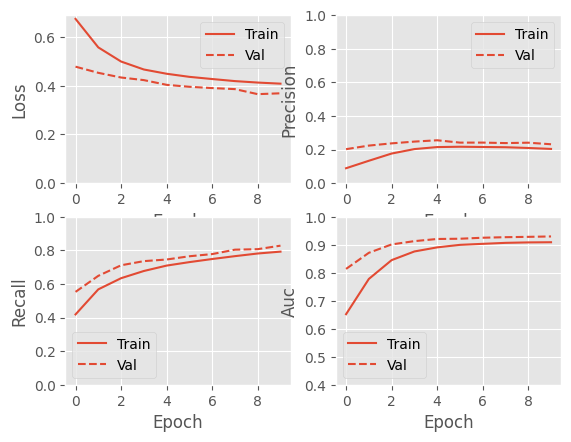

In [15]:
vz.plot_wmetrics(weighted_history)

In [16]:
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

91/91 [==============================] - 0s 1ms/step


In [17]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No-Outliers Detected (True Negatives): ', cm[0][0])
    print('Legitimate No-Outliers Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Outliers Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Outliers Detected (True Positives): ', cm[1][1])
    print('Total Outliers: ', np.sum(cm[1]))
    print('Total No-Outliers: ', np.sum(cm[0]))

Legitimate No-Outliers Detected (True Negatives):  155321
Legitimate No-Outliers Incorrectly Detected (False Positives):  22095
Fraudulent Outliers Missed (False Negatives):  1426
Fraudulent Outliers Detected (True Positives):  6416
Total Outliers:  7842
Total No-Outliers:  177416


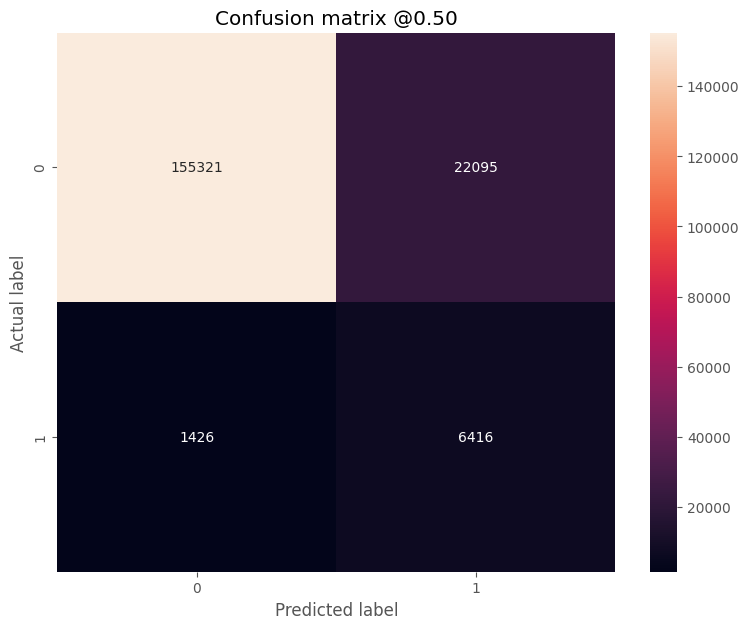

In [18]:
plot_cm(test_labels, test_predictions_weighted)

In [19]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', np.round(value, 2))

f1 = (2*weighted_results[2]*weighted_results[3])/(weighted_results[2]+weighted_results[3])
print("f1 : ", np.round(f1, 2))

loss :  0.37
accuracy :  0.87
precision :  0.23
recall :  0.82
auc :  0.93
f1 :  0.35


# Decile Analysis

In [20]:
decile_analysis = fn.decile_analysis(test_predictions_weighted, test_labels)
decile_analysis

,Batch,Cumulative Batch,Cumulative % Batch,True label,True label %,Cumulative label %,Probability Range
Decile,,,,,,,
1,18526,18526,0.1,5592,0.7131,0.7131,1.0 - 0.617
2,18526,37052,0.2,1249,0.1593,0.8724,0.617 - 0.4182
3,18526,55578,0.3,552,0.0704,0.9427,0.4182 - 0.2983
4,18526,74104,0.4,219,0.0279,0.9707,0.2982 - 0.222
5,18526,92630,0.5,89,0.0113,0.9820,0.222 - 0.1705
6,18526,111156,0.6,65,0.0083,0.9903,0.1705 - 0.1338
7,18526,129682,0.7,38,0.0048,0.9952,0.1338 - 0.1055
8,18526,148208,0.8,14,0.0018,0.9969,0.1055 - 0.0842
9,18525,166733,0.9,1,0.0001,0.9971,0.0842 - 0.0614


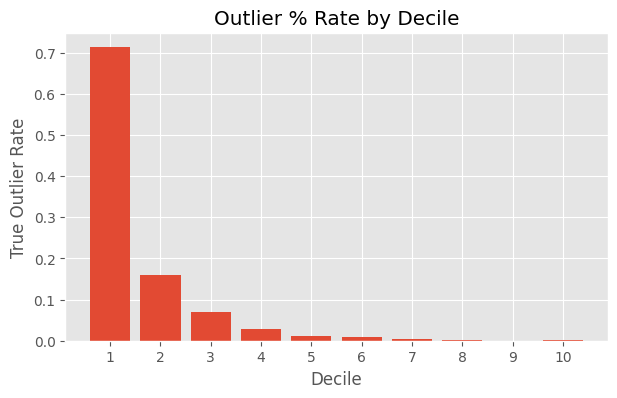

In [21]:
vz.decile_analysis_plot(decile_analysis["True label %"])

In [26]:
test_predictions_weighted = test_predictions_weighted.ravel()
test_predictions_weighted

array([0.11813324, 0.12100265, 0.18308161, ..., 0.04206384, 0.26897025,
       0.20801258], dtype=float32)

In [34]:
x = pd.qcut(test_predictions_weighted, 10)
x

[(0.106, 0.134], (0.106, 0.134], (0.171, 0.222], (0.222, 0.298], (0.0614, 0.0842], ..., (0.0842, 0.106], (-0.001, 0.0614], (-0.001, 0.0614], (0.222, 0.298], (0.171, 0.222]]
Length: 185258
Categories (10, interval[float64, right]): [(-0.001, 0.0614] < (0.0614, 0.0842] < (0.0842, 0.106] < (0.106, 0.134] ... (0.222, 0.298] < (0.298, 0.418] < (0.418, 0.617] < (0.617, 1.0]]

In [62]:
z = pd.DataFrame(
    data = {
        "interval": x,
        "prob": test_predictions_weighted
    }
).sort_values(by = "prob")[::-1]
z

,interval,prob
181805,"(0.617, 1.0]",1.0
148359,"(0.617, 1.0]",1.0
11667,"(0.617, 1.0]",1.0
110423,"(0.617, 1.0]",1.0
133088,"(0.617, 1.0]",1.0
...,...,...
94760,"(-0.001, 0.0614]",0.0
79953,"(-0.001, 0.0614]",0.0
35986,"(-0.001, 0.0614]",0.0
98189,"(-0.001, 0.0614]",0.0


In [69]:
z = z.join(test_df)

In [70]:
z.reset_index(inplace=True)
z.drop(columns=["index"], inplace=True)

In [72]:
z.groupby(by = "interval").mean()

,prob,clave_aduana,fraccion,precio_unitario,cantidad_mercancia,clave_tarifa,tipo_cambio,total_fletes,total_seguros,total_embalajes,total_incrementales,total_deducibles,month,year,first word,Impuestos,pais,poliester,algodon,viscosa,rayon,acrilico,lino,lana,poliamida,elastano,poliuretano,otro
interval,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(-0.001, 0.0614]",0.037098,332.651625,6.087065e+07,296.457549,4333.135082,5.322196,20.430532,23583.793479,297.100939,38.946292,5145.860412,6.724063,5.854313,2020.451636,2743.257152,0.130587,85.055813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.0614, 0.0842]",0.073963,332.362841,6.085678e+07,293.615137,5714.055940,5.343625,20.440611,23515.996653,253.044100,35.189302,5263.105743,0.000000,5.867106,2020.444348,2754.443053,0.132112,84.529958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.0842, 0.106]",0.094254,334.721742,6.085309e+07,310.436373,2797.237482,5.343409,20.442076,19467.048257,16078.951528,27.846972,4294.552791,0.017975,5.891612,2020.445158,2755.941865,0.131550,84.733348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.106, 0.134]",0.119191,331.886964,6.084647e+07,291.799514,3826.312895,5.342240,20.431570,19728.906505,270.905641,35.056410,9628.594926,0.000000,5.859217,2020.450958,2766.008583,0.131290,85.509528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005398
"(0.134, 0.171]",0.151287,333.348338,6.090047e+07,313.282882,10742.178459,5.345531,20.444218,22942.994657,253.196783,30.806239,6964.357945,0.000000,5.903659,2020.448133,2747.103303,0.130964,84.500108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.171, 0.222]",0.195009,332.763118,6.084091e+07,284.295610,7574.064702,5.317696,20.442881,18169.702386,265.192237,70.062891,8058.249136,14.674314,5.886634,2020.449849,2775.559760,0.129462,84.756586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.222, 0.298]",0.257549,331.137922,6.087315e+07,301.005641,3319.174480,5.329555,20.451774,23812.036545,276.909042,43.667638,5724.076653,0.000000,5.881350,2020.445452,2742.015978,0.132035,84.458030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.298, 0.418]",0.352805,332.896254,6.085134e+07,292.054594,3656.526671,5.336662,20.440026,18392.267246,262.604718,41.313667,7305.319983,0.000000,5.856526,2020.450016,2757.265303,0.130522,85.017651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
"(0.418, 0.617]",0.511422,331.027367,6.085577e+07,310.565889,4088.750174,5.327540,20.440014,18639.577998,263.548850,43.792454,5866.257746,0.000000,5.889399,2020.446885,2752.338335,0.131148,85.061751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
